In [1]:
!pip install finance

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for finance: filename=finance-0.2502-py3-none-any.whl size=49722 sha256=41dd6625fc3543fca996e4d183c71cd9f94ae262fbe369e3b3c8e304c3d97ca6
  Stored in directory: c:\users\igorc\appdata\local\pip\cache\wheels\37\fb\30\5deaf1f0cea9fc88498b453007c635dd9a1c16346a0109c9f5
Successfully built finance


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Baixando dados...


C:\Users\igorc\AppData\Local\Temp\ipykernel_14128\1130888360.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_data.rename(columns=names_map, inplace=True)



--- FASE 2: Relatório de Performance ---
 Retorno Anual Volatilidade Sharpe Ratio Max Drawdown Skewness Kurtosis É Normal?
Petrobras 24.37% 40.04% 0.36 -63.36% -1.29 24.93 False
IBOVESPA 8.78% 23.48% -0.05 -46.82% -1.02 23.58 False
Vale 15.44% 35.98% 0.15 -41.34% -0.00 20.35 False
BTG Pactual 40.22% 45.74% 0.66 -68.01% 0.20 18.89 False
Weg 29.41% 35.46% 0.55 -49.51% -0.27 12.32 False
Itau 9.46% 29.62% -0.02 -44.34% -0.37 10.94 False
Renner -9.31% 44.78% -0.43 -76.38% -0.12 7.45 False
Magalu -22.41% 65.98% -0.49 -97.73% 0.32 7.04 False
Taesa 18.47% 18.79% 0.45 -23.69% 0.05 6.35 False


--- Gerando Dashboard Visual... ---


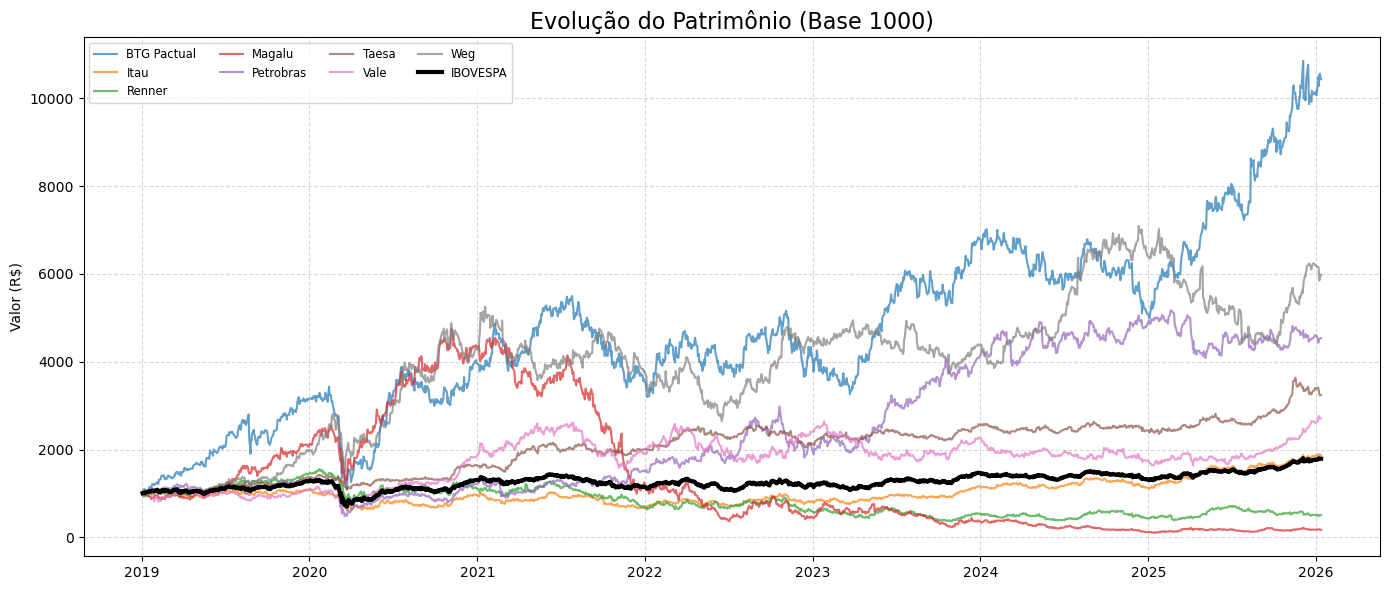

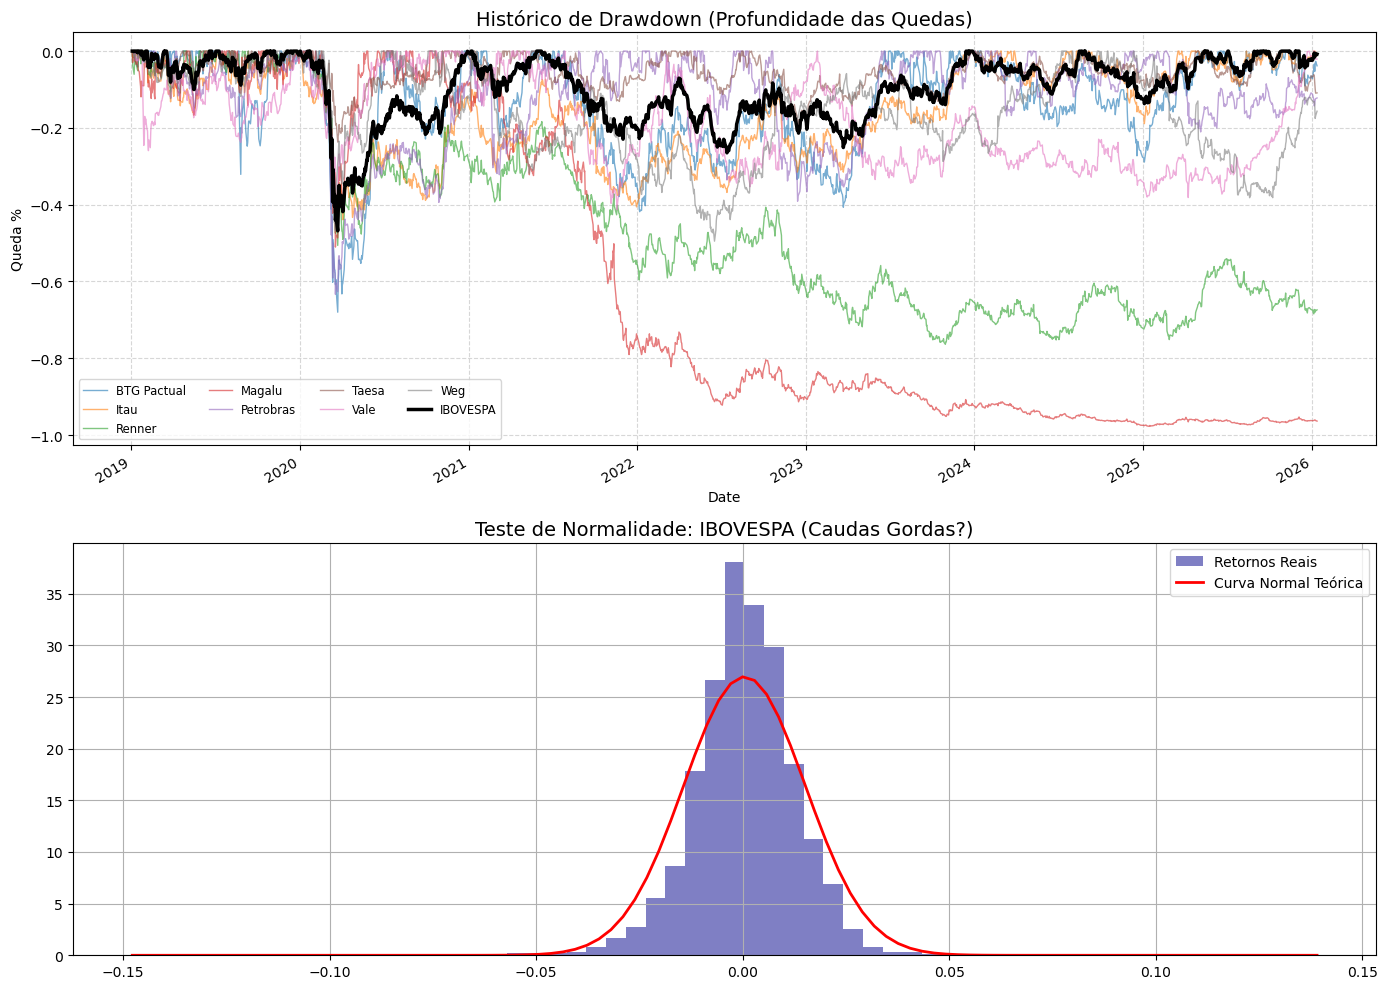

C:\Users\igorc\AppData\Local\Temp\ipykernel_14128\1130888360.py:238: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax5.annotate(txt, (x[i], y[i]), xytext=(5, 5), textcoords='offset points', fontsize=11)


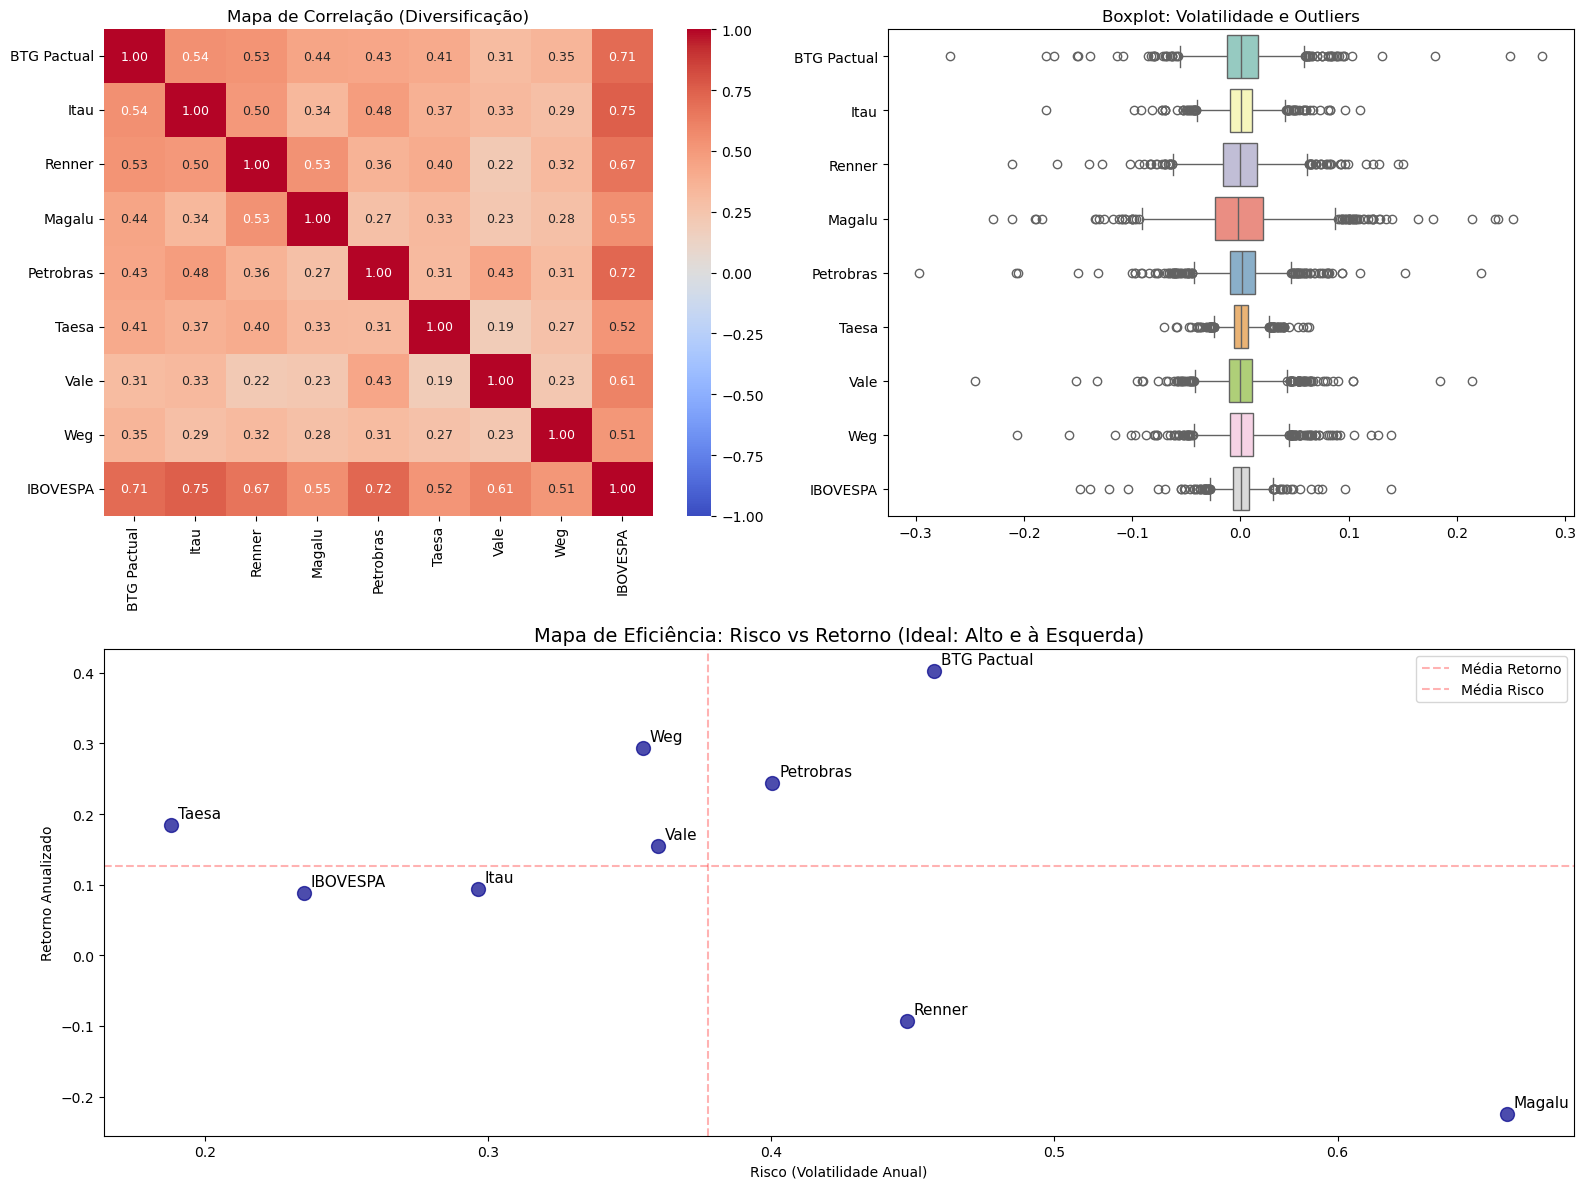

In [5]:
# CONFIGURAÇÃO DO AMBIENTE
%load_ext autoreload
%autoreload 2
    
'''
Com este comando, caso alteradoo o arquivo dados_mercado.py,
o Jupyter recarregue as mudanças automaticamente sem precisar reiniciar o kernel.
'''

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats # Necessário para a Curva Normal
import zipfile
import os
from src import dados_mercado as dm



# -Importação de Módulo
# Como a pasta 'src' está no mesmo local do notebook, o Python a encontra direto.
try:
    from src import dados_mercado as dm
except ImportError:
    # Fallback caso você ainda não tenha criado a pasta src (para o código não quebrar)
    print("ALERTA: Módulo 'src' não encontrado. Certifique-se de criar o arquivo .py")

# Configuração de Ativos.(ETL)

analyzed_groups = {
    'Benchmark': ['^BVSP'],
    'Commodity': ['VALE3.SA', 'PETR4.SA'],
    'Sistema financeiro': ['ITUB4.SA', 'BPAC11.SA'],
    'Varejo': ['MGLU3.SA', 'LREN3.SA'],
    'DEFENSIVA': ['WEGE3.SA', 'TAEE11.SA'],
}

names_map = {
    '^BVSP': 'IBOVESPA',
    'VALE3.SA': 'Vale', 'PETR4.SA': 'Petrobras',
    'ITUB4.SA': 'Itau', 'BPAC11.SA': 'BTG Pactual',
    'MGLU3.SA': 'Magalu', 'LREN3.SA': 'Renner',
    'WEGE3.SA': 'Weg', 'TAEE11.SA': 'Taesa'
}

print("Baixando dados...")
acoes = [ item for sublist in analyzed_groups.values() for item in sublist]

''' Lista de ações e nomes para facilitar o entendimente referidos por nomes das empresas,
craição de função que retorna as ações e facilita o so da lista.
'''

# Extração (DOWNLOAD)

raw_data = yf.download(acoes, start='2019-01-01', auto_adjust=True, ignore_tz=True, progress=False)

# Seleção segura da coluna de Fechamento
try:
    close_data = raw_data['Close']
except KeyError:
    close_data = raw_data

# RENOMEAR:
close_data.rename(columns=names_map, inplace=True)

# Persistência de dados. (Salvando ZIP)

data_folder = 'dados'
csv_filename = 'cotacoes_acoes.csv'
zip_filename = 'cotacoes_acoes.zip'

# Caminho
csv_path = os.path.join(data_folder, csv_filename)
zip_path = os.path.join(data_folder, zip_filename)

# Criar Pasta.
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print(f"\nPasta '{data_folder}' criada com sucesso.")

# Salvando csv temporario.
close_data.to_csv(csv_path)

'''
Fonte de Dados

Os dados financeiros foram inicialmente obtidos via [yfinance](https://pypi.org/project/yfinance/).
No entanto, para evitar problemas recorrentes de instabilidade ou mudanças na API, optei por baixar os dados e tratá-los como artefatos temporários do pipeline.

Dessa forma:
- **Evito bugs** relacionados ao yfinance.
- **Garanto reprodutibilidade** dos experimentos.
- **Otimizo performance** ao trabalhar com versões comprimidas dos arquivos.

'''

# Compactar para ZIP.
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_path, arcname=csv_filename)

# Remoção de CSV, para manter apenas ZIP.
if os.path.exists(zip_path):
    os.remove(csv_path)

print(f"\n--- FASE 2: Relatório de Performance ---")

# Lendo do ZIP recém-criado.
df = pd.read_csv(zip_path, index_col='Date', parse_dates=True)
retornos = df.pct_change().dropna()

# Parâmetros
dias_ano = 252
taxa_livre_risco = 0.10 # Vamos assumir CDI/Selic de 10% ao ano

# Cálculos para TODA a carteira (Usando o módulo 'dm')
ret_anual = dm.annualize_rets(retornos, dias_ano)
vol_anual = dm.annualize_vol(retornos, dias_ano)
sharpe = dm.sharpe_ratio(retornos, taxa_livre_risco, dias_ano)
skew = retornos.apply(dm.skewness)
kurt = retornos.apply(dm.kurtosis)
max_dd = retornos.apply(lambda x: dm.drawdown(x)['Drawdown'].min())

# Teste Rápido: O ativo é Normal? (Simples verificação)
is_normal = kurt.apply(lambda x: x < 3.5 and x > 2.5)

# Montar Tabela Final "Pro"
tabela = pd.DataFrame({
    "Retorno Anual": ret_anual,
    "Volatilidade": vol_anual,
    "Sharpe Ratio": sharpe,
    "Max Drawdown": max_dd,
    "Skewness": skew,       # Nova coluna
    "Kurtosis": kurt,       # Nova coluna
    "É Normal?": is_normal  # Nova coluna (Diagnóstico)
})

# Ordenar por Kurtosis (Risco de Cauda)
print(tabela.sort_values(by="Kurtosis", ascending=False).style.format({
    "Retorno Anual": "{:.2%}",
    "Volatilidade": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Max Drawdown": "{:.2%}",
    "Skewness": "{:.2f}",
    "Kurtosis": "{:.2f}"
}).to_string())

# ==============================================================================
# 5. VISUALIZAÇÃO 
# ==============================================================================

print("\n--- Gerando Dashboard Visual... ---")

# --- PARTE A: Evolução do Patrimônio (O Gráfico que faltava) ---
fig0, ax0 = plt.subplots(figsize=(14, 6))

# Calcula o Wealth Index (Começando com 1000)
wealth_index = 1000 * (1 + retornos).cumprod()

colors = sns.color_palette("tab10", len(retornos.columns))
for i, col in enumerate(wealth_index.columns):
    # Destaque visual para o Benchmark (Linha Preta Grossa)
    lw = 3 if col == 'IBOVESPA' else 1.5
    alpha = 1.0 if col == 'IBOVESPA' else 0.7
    color = 'black' if col == 'IBOVESPA' else colors[i]
    style = '-' # Linha sólida
    
    # Plota a linha
    ax0.plot(wealth_index.index, wealth_index[col], label=col, linewidth=lw, alpha=alpha, color=color, linestyle=style)

ax0.set_title('Evolução do Patrimônio (Base 1000)', fontsize=16)
ax0.set_ylabel('Valor (R$)')
ax0.legend(loc='upper left', ncol=4, fontsize='small')
ax0.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- PARTE B: Risco e Distribuição ---
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# B1. Drawdown Histórico
for i, col in enumerate(retornos.columns):
    dd = dm.drawdown(retornos[col])['Drawdown']
    
    lw = 2.5 if col == 'IBOVESPA' else 1
    alpha = 1.0 if col == 'IBOVESPA' else 0.6
    color = 'black' if col == 'IBOVESPA' else colors[i]
    
    dd.plot(ax=ax1, label=col, linewidth=lw, alpha=alpha, color=color)

ax1.set_title('Histórico de Drawdown (Profundidade das Quedas)', fontsize=14)
ax1.set_ylabel('Queda %')
ax1.legend(loc='lower left', ncol=4, fontsize='small')
ax1.grid(True, linestyle='--', alpha=0.5)

# B2. Histograma com Curva Normal (IBOVESPA)
target = 'IBOVESPA'
if target in retornos.columns:
    retornos[target].hist(ax=ax2, bins=60, density=True, color='darkblue', alpha=0.5, label='Retornos Reais')
    
    # Curva Teórica
    mu, std = retornos[target].mean(), retornos[target].std()
    x = np.linspace(retornos[target].min(), retornos[target].max(), 100)
    p = stats.norm.pdf(x, mu, std)
    ax2.plot(x, p, 'r', linewidth=2, label='Curva Normal Teórica')
    
    ax2.set_title(f'Teste de Normalidade: {target} (Caudas Gordas?)', fontsize=14)
    ax2.legend()

plt.tight_layout()
plt.show()

# --- PARTE C: Análise Estatística (Heatmap, Boxplot, Scatter) ---
fig2 = plt.figure(figsize=(16, 12))
gs = fig2.add_gridspec(2, 2)

# C1. Heatmap de Correlação
ax3 = fig2.add_subplot(gs[0, 0])
corr = retornos.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax3, fmt=".2f", annot_kws={"size": 9})
ax3.set_title('Mapa de Correlação (Diversificação)', fontsize=12)

# C2. Boxplot (Outliers)
ax4 = fig2.add_subplot(gs[0, 1])
sns.boxplot(data=retornos, ax=ax4, orient='h', palette='Set3')
ax4.set_title('Boxplot: Volatilidade e Outliers', fontsize=12)

# C3. Scatter Plot: Risco x Retorno (Eficiência)
ax5 = fig2.add_subplot(gs[1, :])
x = tabela['Volatilidade']
y = tabela['Retorno Anual']

ax5.scatter(x, y, s=100, c='darkblue', alpha=0.7)

# Adicionar rótulos
for i, txt in enumerate(tabela.index):
    ax5.annotate(txt, (x[i], y[i]), xytext=(5, 5), textcoords='offset points', fontsize=11)

# Quadrantes
ax5.axhline(y.mean(), color='red', linestyle='--', alpha=0.3, label='Média Retorno')
ax5.axvline(x.mean(), color='red', linestyle='--', alpha=0.3, label='Média Risco')

ax5.set_title('Mapa de Eficiência: Risco vs Retorno (Ideal: Alto e à Esquerda)', fontsize=14)
ax5.set_xlabel('Risco (Volatilidade Anual)')
ax5.set_ylabel('Retorno Anualizado')
ax5.legend()

plt.tight_layout()
plt.show()